In [1]:
import pandas as pd
import numpy as np
import scipy as scp 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
app_df = pd.read_csv("./CC-Approval-Prediction/application_record.csv")
cr_df = pd.read_csv("./CC-Approval-Prediction/credit_record.csv")

print(app_df.shape)
print(cr_df.shape)

(438557, 18)
(1048575, 3)


In [3]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
cr_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


###### Compute if the history of credit records for a given client is present till date or cancelled before the current date 

In [5]:
grp_df = cr_df.groupby("ID").agg(count=('MONTHS_BALANCE', np.count_nonzero), \
                                max_history=('MONTHS_BALANCE', np.min)).reset_index()

grp_df['max_history'] = grp_df['max_history'].apply(lambda x: -x)
grp_df.head()

,ID,count,max_history
0,5001711,3,3
1,5001712,18,18
2,5001713,21,21
3,5001714,14,14
4,5001715,59,59


In [6]:
print("{} clients don't have credit report record till curr month".format(grp_df[grp_df['count'] != grp_df['max_history']].shape[0]))
print("{} clients having credit report info till curr month".format(grp_df[grp_df['count'] == grp_df['max_history']].shape[0]))
grp_df[grp_df['count'] != grp_df['max_history']].head()

11179 clients don't have credit report record till curr month
34806 clients having credit report info till curr month


,ID,count,max_history
3235,5008809,5,26
3238,5008812,17,20
3242,5008819,8,17
3243,5008820,9,16
3245,5008822,9,22


###### Compute cumulative bad & good percentages from the starting point

In [7]:
def compute_good_bad_labels(p_df):
    
    f_temp = p_df[p_df['STATUS'].isin(["3", "4", "5"])]
    
    if len(f_temp) > 0: 
        return pd.Series({'label': 'bad'})
    else:
        return pd.Series({'label': 'good'})

###### compute count of bad & good ID's based on the status.

###### Assuming if someone has 3, 4 or 5 as status in Credit report, consider them as bad.

In [8]:
g1 = cr_df.groupby("ID", group_keys=True)
    
client_label_df = g1[['MONTHS_BALANCE', 'STATUS']].apply(lambda x: compute_good_bad_labels(x)).reset_index()
client_label_df.label.value_counts()

good    45654
bad       331
Name: label, dtype: int64

In [9]:
client_label_df[client_label_df.label == 'good'].sample()

,ID,label
11197,5025097,good


In [10]:
pivot_df = cr_df.groupby("ID").agg(open_month=("MONTHS_BALANCE", np.min), \
                    end_month=("MONTHS_BALANCE", np.max)).reset_index()

pivot_df["window"] = pivot_df["end_month"] - pivot_df["open_month"]


credit_df = pd.merge(cr_df, pivot_df, on = 'ID', how = 'left') # join calculated information
credit_df['risk_flag'] = credit_df.apply(lambda x: int(x['STATUS'] in ['3', '4', '5']), axis = 1)
credit_df['month_on_book'] = (credit_df['MONTHS_BALANCE'] - credit_df['open_month']) + 1

###### 5024071, 5042064 these ID's have status as 5 on the starting month itself. 
###### Typiclly we need to wait atleast 150 days to see the risk status as 5. Not sure if this is due to some bug in the data...

In [11]:
credit_df[(credit_df.risk_flag == 1)].sort_values(by=['month_on_book'])

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,risk_flag,month_on_book
269197,5024071,-38,5,-38,0,38,1,1
372060,5042064,-52,5,-53,-35,18,1,2
271885,5024213,-42,5,-43,-35,8,1,2
1005684,5145817,-38,5,-39,0,39,1,2
998568,5143342,-30,5,-32,0,32,1,3
...,...,...,...,...,...,...,...,...
947072,5135636,0,5,-59,0,59,1,60
77254,5005205,-1,5,-60,0,60,1,60
598358,5069475,0,5,-60,0,60,1,61
77253,5005205,0,5,-60,0,60,1,61


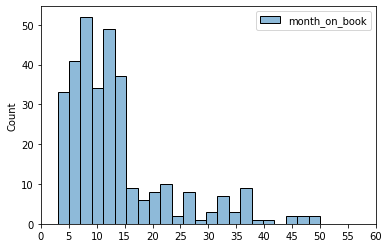

In [12]:
fig, ax = plt.subplots()
sns.histplot(credit_df[(credit_df.STATUS == '3')][["month_on_book"]], ax=ax)

ax.set_xticks(range(0, 61, 5))
ax.set_xticklabels([val for val in range(0, 61, 5)])
plt.show()

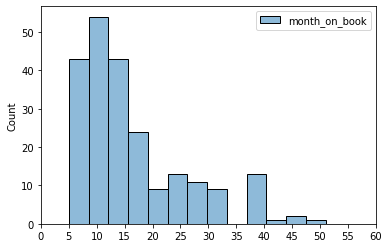

In [13]:
fig, ax = plt.subplots()
sns.histplot(credit_df[(credit_df.STATUS == '4')][["month_on_book"]], ax=ax)

ax.set_xticks(range(0, 61, 5))
ax.set_xticklabels([val for val in range(0, 61, 5)])
plt.show()

###### Discard/Drop samples where status is in (3, 4, 5) and this status falling in the first 4 months.

In [14]:
bad_cond = ((credit_df['risk_flag'] == 1) & (credit_df['month_on_book'] > 3))
first_risk_info = credit_df[bad_cond].groupby("ID")["month_on_book"].min().reset_index()
first_risk_info.columns = ["ID", "risk_start_month"]
first_risk_info.head()

,ID,risk_start_month
0,5002126,8
1,5003267,4
2,5003471,9
3,5003712,15
4,5003804,11


In [15]:
first_risk_info.risk_start_month.describe()

count    328.000000
mean      13.323171
std        9.054666
min        4.000000
25%        7.000000
50%       11.000000
75%       15.000000
max       59.000000
Name: risk_start_month, dtype: float64

In [16]:
np.quantile(first_risk_info.risk_start_month, q=[0.8, 0.9, 0.95])

array([18.6, 27. , 32. ])

###### Most of the event related to '3', '4' & '5'  Occurs within first 15 months only. 
###### 90% of the customers are identified in the first 27 months window.
###### 95% of the bad customers are identified in the first 32 months window


###### We can consider the window for good book clients to be something months between 27 to 32 months.


###### For this problem, lets say our period of study is 30 months. (2.5 years)

1. Get all the instances of IDs where window is greater than 30 months and with no STATUS in credit report being (3, 4, 5)
    Mark these clients as Good book.
    
2. Get all the instances of IDs where window is > 3 and window <= 30 and with Status in credit report contains atleast (3,4,5).
    Mark these clients as bad clients. Discard ID's where status is in (3, 4, 5) and opening month of the report is less than 3 months.
    

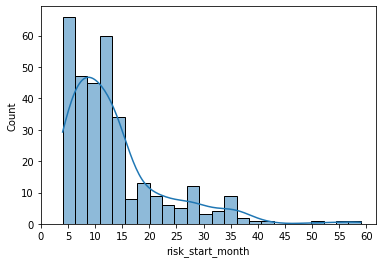

In [17]:
fig, ax = plt.subplots()
sns.histplot(first_risk_info.risk_start_month, ax= ax, kde=True)
ax.set_xticks(range(0, 61, 5))
ax.set_xticklabels([val for val in range(0, 61, 5)])
plt.show()

<AxesSubplot:xlabel='risk_start_month', ylabel='Density'>

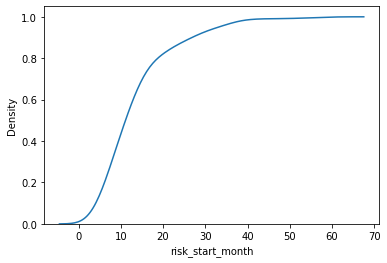

In [18]:
sns.kdeplot(first_risk_info.risk_start_month, cumulative=True)

In [19]:
bad_list = credit_df[(credit_df['risk_flag'] == 1)]['ID'].unique()

temp = credit_df[((~credit_df['ID'].isin(bad_list)) & (credit_df['window'] > 30))]
gb_clients = temp.groupby('ID')["STATUS"].nunique().sort_values(ascending=False).reset_index()
gb_clients.columns = ['ID', 'status_count']
gb_list = gb_clients[gb_clients.status_count > 1].ID.tolist()
len(gb_list)

11176

In [20]:
gb_clients.sample()

,ID,status_count
1624,5137543,3


In [21]:
cr_df[cr_df["ID"].isin([5061023])].sort_values(by='MONTHS_BALANCE')

,ID,MONTHS_BALANCE,STATUS
500784,5061023,-48,X
500783,5061023,-47,0
500782,5061023,-46,0
500781,5061023,-45,0
500780,5061023,-44,C
500779,5061023,-43,C
500778,5061023,-42,C
500777,5061023,-41,C
500776,5061023,-40,C
500775,5061023,-39,C


###### Get good/bad ID's

In [22]:
bad_clients_df = first_risk_info[first_risk_info.risk_start_month <= 30].copy()
bad_clients_df.loc[:, 'label'] = 'bad'

gb_clients_df = credit_df[credit_df['ID'].isin(gb_list)].groupby('ID')['month_on_book'].max().reset_index().copy()
gb_clients_df.columns = ['ID', 'risk_start_month']
gb_clients_df.loc[:, 'label'] = 'good'

assert len(set(bad_clients_df.ID) & set(gb_clients_df.ID)) == 0

In [23]:
label_df = pd.concat([bad_clients_df, gb_clients_df])
label_df.head()

,ID,risk_start_month,label
0,5002126,8,bad
1,5003267,4,bad
2,5003471,9,bad
3,5003712,15,bad
4,5003804,11,bad


In [24]:
label_df['label'].value_counts()

good    11176
bad       306
Name: label, dtype: int64

In [25]:
combined_df = pd.merge(app_df, label_df, how='inner', on='ID')
len(combined_df)

8116

###### Lost some good book and bad book clients as they are not there in application data..

In [26]:
combined_df['label'].value_counts()

good    7838
bad      278
Name: label, dtype: int64

In [29]:
combined_df.to_csv("./CC-Approval-Prediction/label_df.csv", index=False)